# Context
- https://aviation.stackexchange.com/questions/45190/what-is-the-exact-definition-of-taxi-time
- taxi-out = period between actual off-block time (AOBT) and actual take of time (ATOT)
- Data used: https://www.kaggle.com/datasets/deepankurk/flight-take-off-data-jfk-airport

# Initial Inspection

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler

from data_processing import remove_xa0_and_convert_to_int64

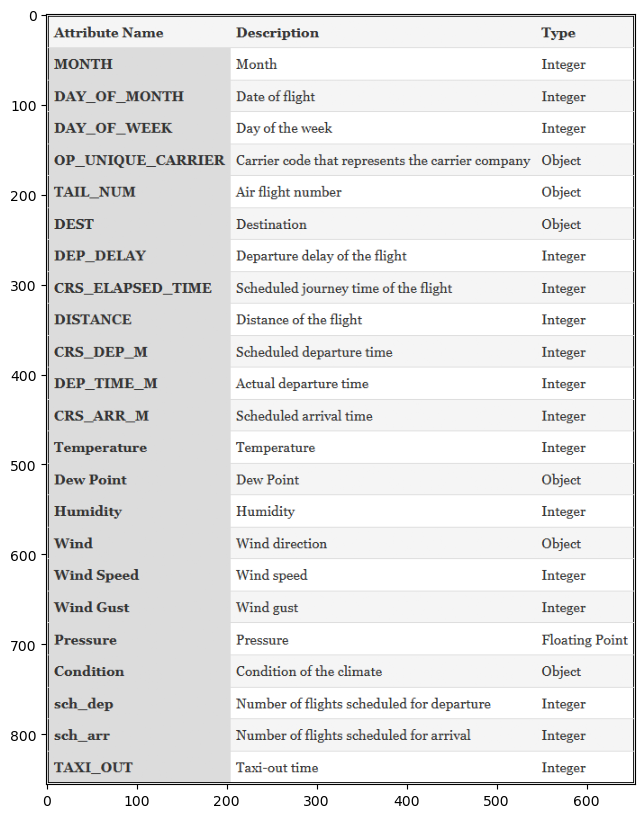

In [2]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
img = plt.imread('img/definition-of-terms.png')
ax.imshow(img)

In [3]:
df_takeoff = pd.read_csv('data/M1_final.csv')
df_takeoff.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [4]:
df_takeoff.info() # not many null values :)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [5]:
# Only `Wind` has null values
df_takeoff.isna().sum()

MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
TAIL_NUM             0
DEST                 0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
CRS_DEP_M            0
DEP_TIME_M           0
CRS_ARR_M            0
Temperature          0
Dew Point            0
Humidity             0
Wind                 2
Wind Speed           0
Wind Gust            0
Pressure             0
Condition            0
sch_dep              0
sch_arr              0
TAXI_OUT             0
dtype: int64

Since there are only 2 null values out of 28,000 rows, we shall simply remove these values during the preprocessing stage of the final model.

In [6]:
half_cols = (df_takeoff.columns.shape[0] // 2) + 1 # plus one to put CRS_ARR_M in this table
df_takeoff.iloc[:, :half_cols].describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,7.894240,16.021096,4.008952,6.374983,225.288203,1267.746079,831.003851,828.934698,910.874289
std,4.991723,8.750179,1.985230,38.735144,119.482417,889.343246,299.398525,305.864103,345.411743
min,1.000000,1.000000,1.000000,-22.000000,57.000000,94.000000,301.000000,1.000000,1.000000
25%,1.000000,8.000000,2.000000,-6.000000,124.000000,483.000000,545.000000,542.000000,667.000000
50%,11.000000,16.000000,4.000000,-3.000000,188.000000,1029.000000,856.000000,854.000000,918.000000
75%,12.000000,24.000000,6.000000,2.000000,365.000000,2248.000000,1095.000000,1097.000000,1193.000000
max,12.000000,31.000000,7.000000,1276.000000,697.000000,4983.000000,1439.000000,1440.000000,1439.000000


In [7]:
df_takeoff.iloc[:, half_cols:].describe()

,Temperature,Humidity,Wind Speed,Wind Gust,Pressure,sch_dep,sch_arr,TAXI_OUT
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,41.489833,57.732616,12.367627,5.535323,30.092433,31.091256,28.432130,20.858570
std,8.043533,23.468676,6.259298,11.886457,0.296160,9.510359,8.263043,6.851915
min,17.000000,0.000000,0.000000,0.000000,29.200000,0.000000,0.000000,5.000000
25%,36.000000,46.000000,8.000000,0.000000,29.880000,26.000000,21.000000,16.000000
50%,42.000000,59.000000,12.000000,0.000000,30.110000,30.000000,30.000000,19.000000
75%,47.000000,74.000000,16.000000,0.000000,30.320000,37.000000,35.000000,25.000000
max,68.000000,97.000000,36.000000,49.000000,30.750000,55.000000,46.000000,41.000000


In [8]:
df_takeoff.select_dtypes(['int64', 'float64']) \
    .corrwith(df_takeoff['TAXI_OUT']) \
    .sort_values(ascending=False)

TAXI_OUT            1.000000
sch_dep             0.190101
Wind Gust           0.095643
CRS_ARR_M           0.071377
CRS_ELAPSED_TIME    0.070838
sch_arr             0.064284
Wind Speed          0.062522
DISTANCE            0.059856
DEP_TIME_M          0.057896
CRS_DEP_M           0.044864
DEP_DELAY           0.034881
DAY_OF_WEEK         0.028388
MONTH               0.018505
DAY_OF_MONTH       -0.023990
Humidity           -0.026826
Pressure           -0.059290
Temperature        -0.067574
dtype: float64

There seems to only be weak linear correlation between `TAXI_OUT` and any of the other features in the dataset. Is there non-linear correlation? We will explore further along in this notebook.

# Categorical Data Types

In [9]:
categorical_cols = df_takeoff.select_dtypes(['object']).columns.to_list()
for col in categorical_cols:
    if col == 'TAIL_NUM':
        # Skip `TAIL_NUM` because there is a unique one for 
        # each plane and it should not affect `TAXI_OUT`
        continue
    print(f'{col}: {df_takeoff[col].unique().tolist()}')

OP_UNIQUE_CARRIER: ['B6', 'DL', 'AA', 'AS', 'MQ', '9E', 'YX', 'HA', 'OO']
DEST: ['CHS', 'LAX', 'FLL', 'MCO', 'ATL', 'ORD', 'BUF', 'LGB', 'LAS', 'DCA', 'PHX', 'SFO', 'SJU', 'SLC', 'BOS', 'SAV', 'SYR', 'MSP', 'SEA', 'MIA', 'PDX', 'TPA', 'BTV', 'IAH', 'DEN', 'RSW', 'ORF', 'JAX', 'MSY', 'CLT', 'BNA', 'RDU', 'SAN', 'SJC', 'ROC', 'DFW', 'IAD', 'AUS', 'DTW', 'PWM', 'SRQ', 'CMH', 'HNL', 'PBI', 'BWI', 'CLE', 'BUR', 'PIT', 'RIC', 'IND', 'CVG', 'SMF', 'ONT', 'SAT', 'PSP', 'OAK', 'ABQ', 'PSE', 'ORH', 'BQN', 'STT', 'RNO', 'PHL', 'EGE', 'JAC']
Dew Point: ['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39', '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53', '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21', '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15', '17', '26', '25', '51', '55', '6\xa0', '9\xa0', '5\xa0', '8\xa0', '10', '4\xa0', '7\xa0', '3\xa0', '2\xa0', '11', '0\xa0', '-1', '1\xa0', '-2', '-3']
Wind: ['W', 'WNW', 'NW', 'NNW', 'S', '

`Dew Point` has some strange values. `\xa0` appears to be a [non-breaking space](https://en.wikipedia.org/wiki/Non-breaking_space). This should be removed, and then the values may be converted to integers.


In [10]:
df_takeoff['Dew Point'] = df_takeoff['Dew Point'].apply(remove_xa0_and_convert_to_int64)
df_takeoff['Dew Point'].head()

0    34
1    34
2    34
3    34
4    32
Name: Dew Point, dtype: int64

What is dew point? Accorning to [Wikipedia](https://en.wikipedia.org/wiki/Dew_point):

The dew point of a given body of air is the temperature to which it must be cooled to become saturated with water vapor. This temperature depends on the pressure and water content of the air. When the air is cooled below the dew point, its moisture capacity is reduced and airborne water vapor will condense to form liquid water known as dew.[1] When this occurs through the air's contact with a colder surface, dew will form on that surface.[2]

How is dew point correlated with `TAXI_OUT`?

In [11]:
df_takeoff['TAXI_OUT'].corr(df_takeoff['Dew Point'])

0.01021558349049377

... weakly.

In [12]:
df_takeoff['DEST'].unique().shape

(65,)

In [13]:
# Assuming that a plane going to a certain destination departs in the same direction
# each time, would the direction of the wind have a consistent effect?
df_takeoff.loc[:, ['DEST', 'Wind', 'TAXI_OUT']].groupby(['DEST', 'Wind']).mean()

TAXI_OUT
DEST Wind           
ABQ  CALM  29.000000
     E     31.000000
     ENE   22.500000
     ESE   19.000000
     N     27.800000
...              ...
TPA  SW    19.591837
     VAR   17.400000
     W     19.379747
     WNW   20.745098
     WSW   20.113208

[1125 rows x 1 columns]

In [14]:
def group_and_sort(df: pd.DataFrame, group_by: str, sort_by: str) -> pd.DataFrame:
    return df.loc[:, [group_by, sort_by]].groupby(group_by).mean().sort_values(by=sort_by, ascending=False)


def plot_bar(
        df: pd.DataFrame,
        xlabel: str,
        xlabel_rotation: int = 90,
        show_deviation: bool = True
    ):
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(10)
    if show_deviation:
        dev = np.std(df.values.reshape([-1]))
    else:
        dev = None    
    ax.bar(df.index, df.values.reshape([-1]), yerr=dev)
    
    # Format Grid
    fig.suptitle(f'Effect of {xlabel}')
    ax.set_ylabel('Average Taxi Time / minutes')
    ax.set_xlabel(xlabel)
    plt.xticks(rotation=xlabel_rotation)
    ax.set_axisbelow(True) # display grid behind other plot elements
    ax.grid(visible=True, axis='y', which='major', linewidth=0.7, alpha=1.0)
    ax.grid(visible=True, axis='y', which='minor', linewidth=0.5, alpha=0.5)
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.show()

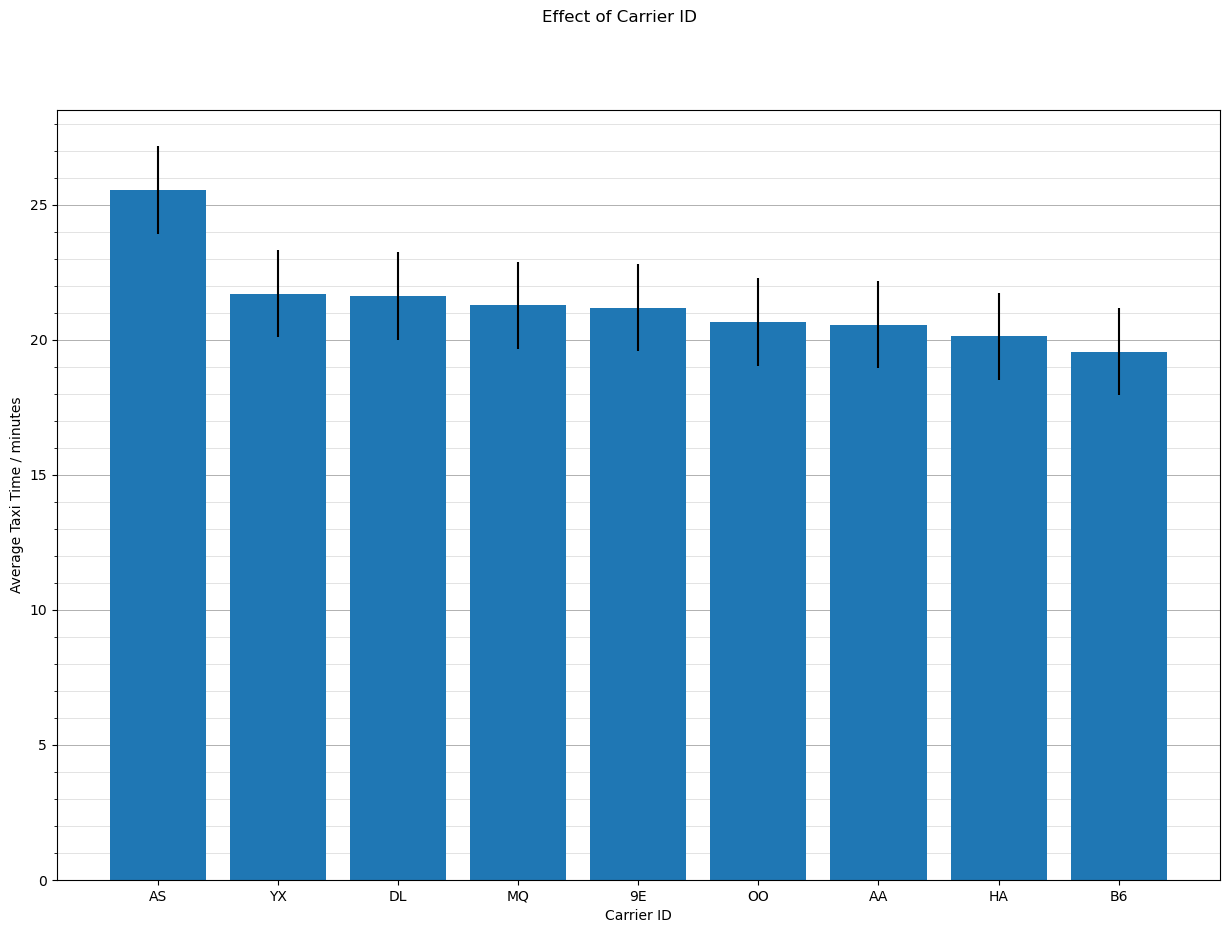

In [15]:
carrier_time = group_and_sort(df_takeoff, 'OP_UNIQUE_CARRIER', 'TAXI_OUT')
plot_bar(carrier_time, 'Carrier ID', xlabel_rotation=0)

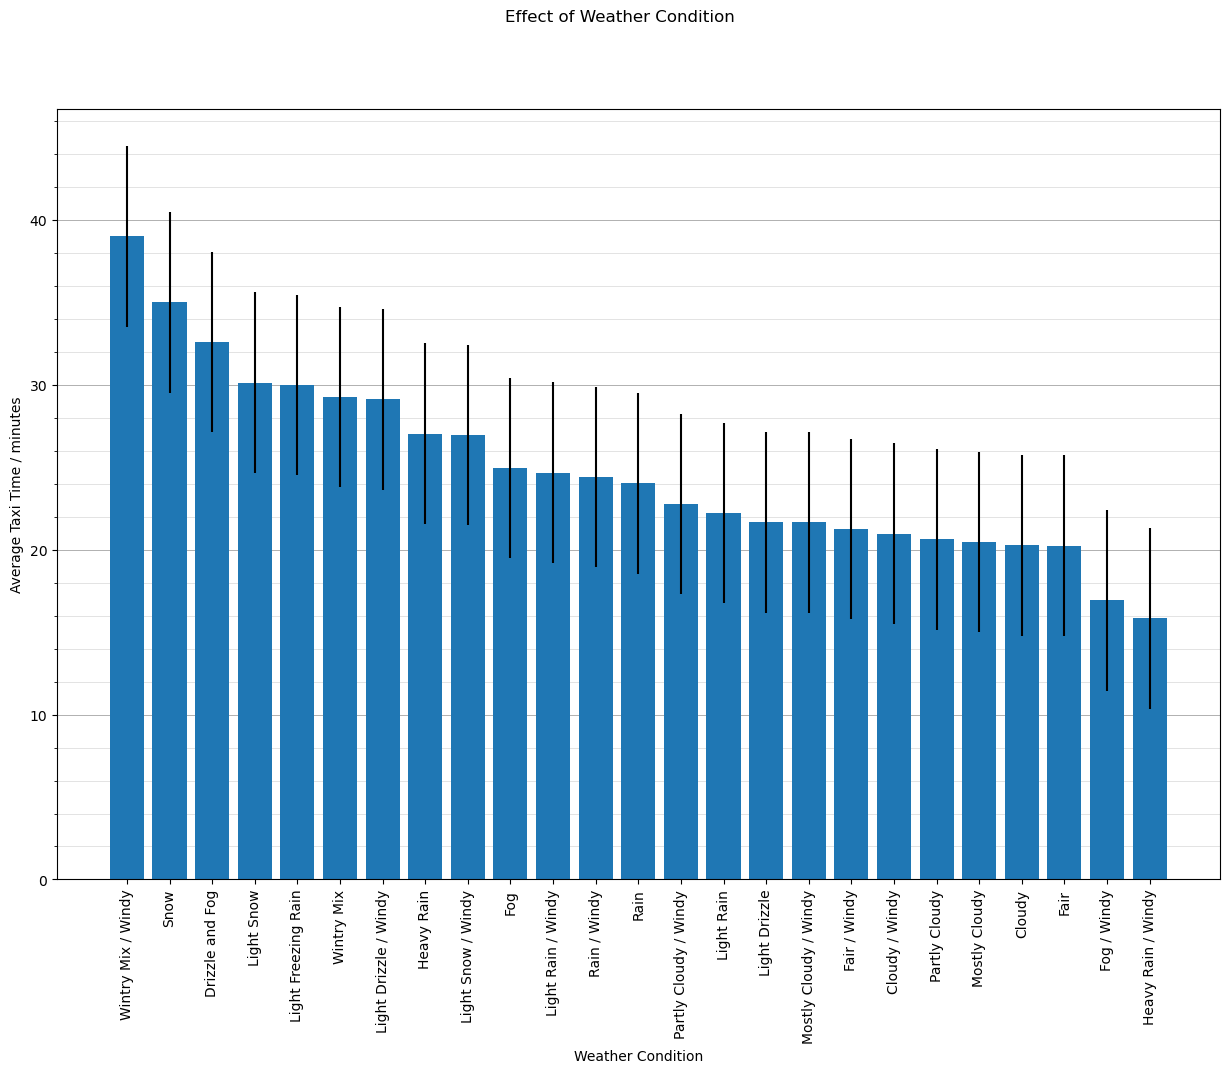

In [16]:
weather_condition = group_and_sort(df_takeoff, group_by='Condition', sort_by='TAXI_OUT')
plot_bar(weather_condition, 'Weather Condition')

Perhaps splitting the weather condition into a matrix containing a binary value for each of the unique conditions (e.g. Rain, Windy, Cloudy) could give the model more information. This is because, for example, 'Heavy Rain / Windy' and 'Heavy Rain' are not two discrete categories but a combination of categores. So, these two may be represented as 'Heavy Rain AND Windy' and 'Heavy Rain AND NOT Windy', respectively.

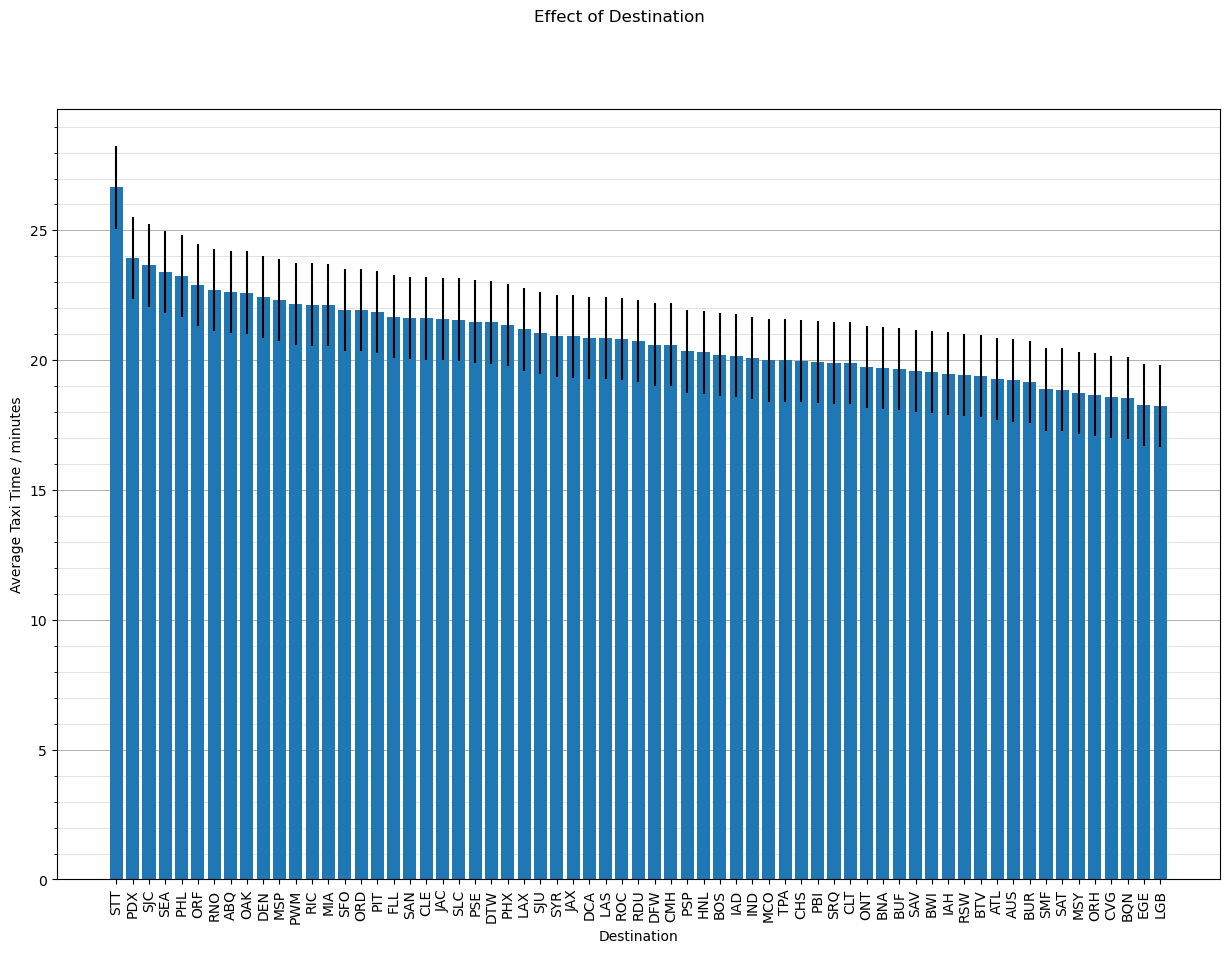

In [17]:
destination = group_and_sort(df_takeoff, 'DEST', 'TAXI_OUT')
plot_bar(destination, 'Destination')

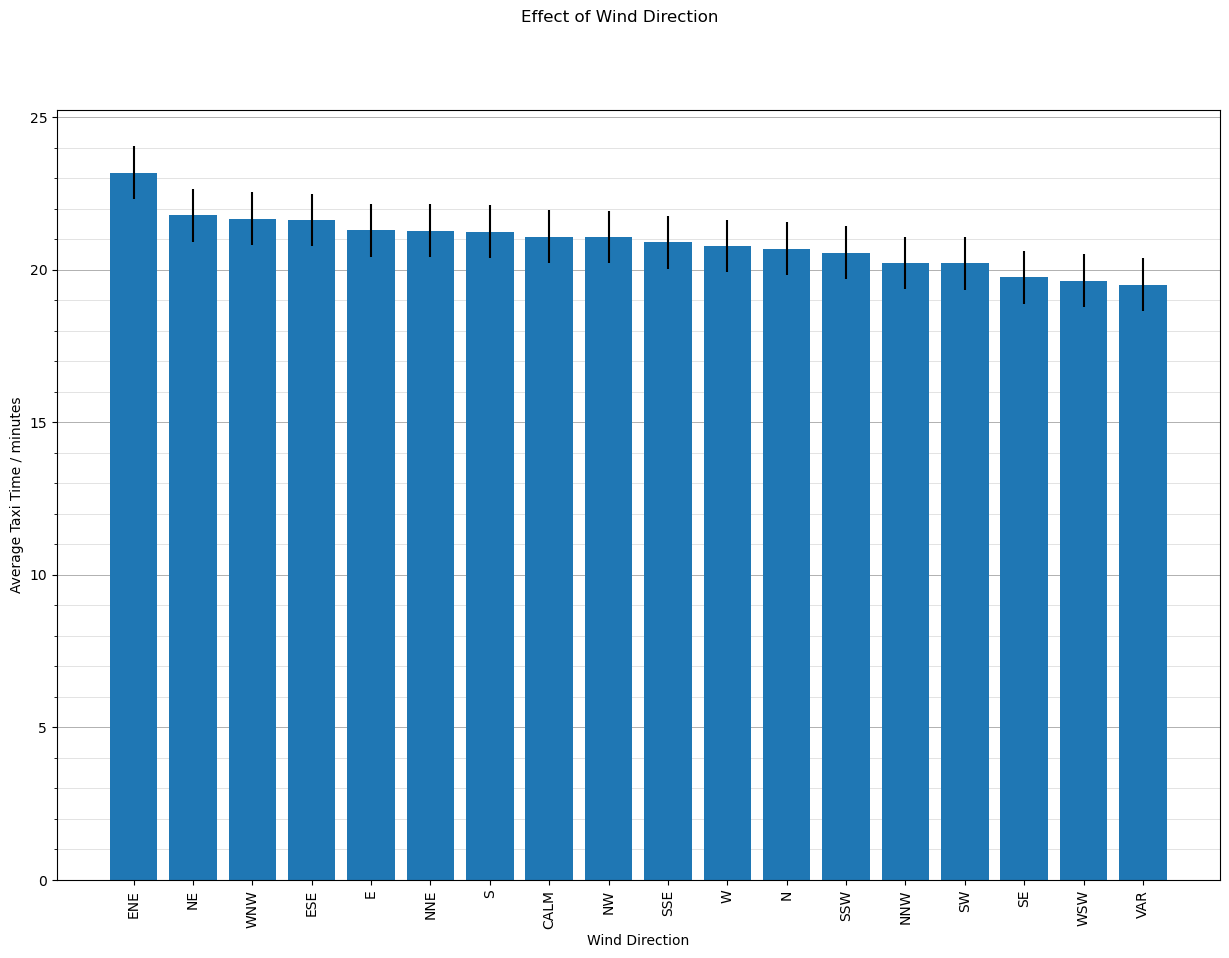

In [18]:
wind_direction = group_and_sort(df_takeoff, 'Wind', 'TAXI_OUT')
plot_bar(wind_direction, 'Wind Direction')

Judging from the mean values, the categorical data also appears to be weakly correlated to `TAXI_OUT`

# Correlation Matrix

<Axes: >

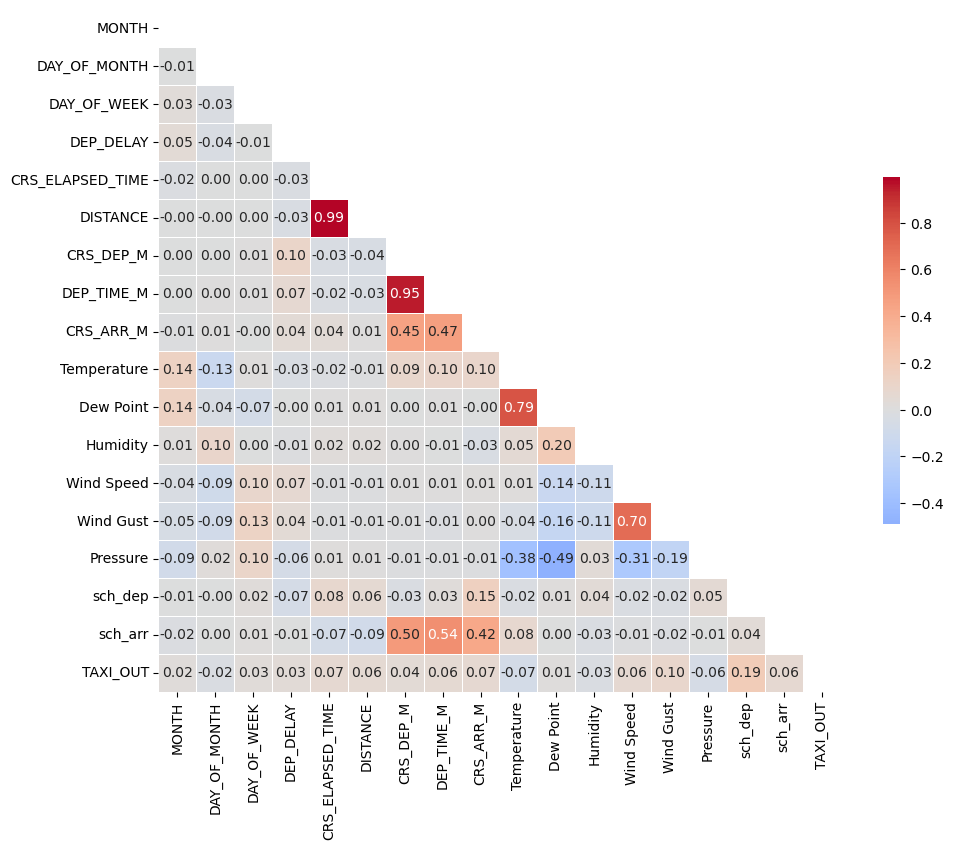

In [19]:
corr = df_takeoff.select_dtypes(['int64', 'float64']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt='.2f')

The matrix shows that there are not many values which are strongly linearly correlated with any other. Dew Point, Pressure, Temperature are reasonably well correlated with each other. As are CRS_DEP_M, DEP_TIME_M, CRS_ARR_M

CRS_DEP_M and DEP_TIME_M are closely correlated since they are the scheduled and actual departure time, respectively.

Importantly, TAXI_TIME is weakly correlated to any of the features.

# What do all these features mean???
Reasoning shown below
#### TL;DR:
- CRS_DEP_M - intended departure time
- CRS_TIME_M - actual departure time
- DEP_DELAY - the difference between the two above (departure delay)
- CRS_ELAPSED_TIME - the difference between CRS_DEP_M and CRS_ARR_M (scheduled flight duration)
- sch_dep - ?
- sch_arr - ?

In [20]:
# DEP_DELAY is the time between scheduled and actual departure
df_takeoff.loc[:5, ['CRS_DEP_M', 'DEP_TIME_M', 'DEP_DELAY']]

,CRS_DEP_M,DEP_TIME_M,DEP_DELAY
0,324,323,-1
1,340,333,-7
2,301,341,40
3,345,343,-2
4,360,356,-4
5,359,358,-1


In [21]:
# CRS_ELAPSED_TIME is the scheduled flight duration
df_takeoff.loc[:5, ['CRS_DEP_M', 'CRS_ARR_M', 'CRS_ELAPSED_TIME']]

,CRS_DEP_M,CRS_ARR_M,CRS_ELAPSED_TIME
0,324,448,124
1,340,531,371
2,301,482,181
3,345,513,168
4,360,499,139
5,359,460,161


<Axes: xlabel='sch_dep', ylabel='Count'>

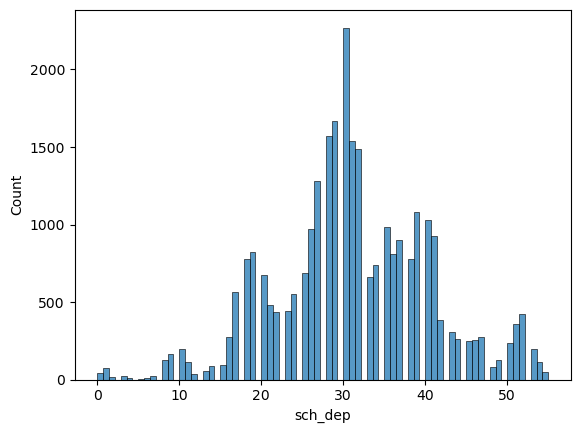

In [22]:
sns.histplot(df_takeoff['sch_dep'])

<Axes: xlabel='sch_arr', ylabel='Count'>

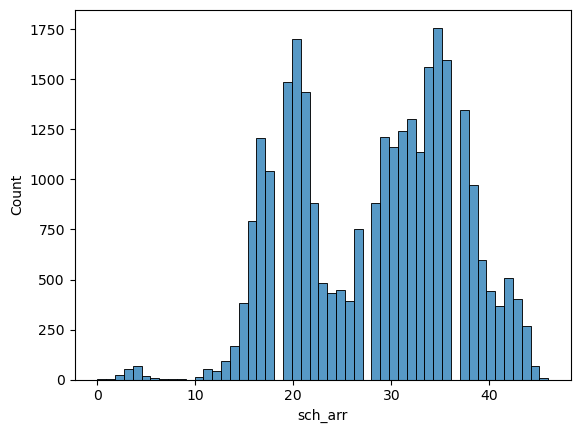

In [23]:
sns.histplot(df_takeoff['sch_arr'])

- 'sch_dep' and 'sch_arr' appear to be within the range 0-60, which makes me suspicious that this is minutes past the hour...
- However they do not match up to the other scheduled departure and arrival features (shown below)

In [24]:
df_takeoff.loc[:10, ['CRS_DEP_M', 'sch_dep', 'CRS_ARR_M', 'sch_arr']]

,CRS_DEP_M,sch_dep,CRS_ARR_M,sch_arr
0,324,9,448,17
1,340,9,531,17
2,301,9,482,17
3,345,9,513,17
4,360,9,499,17
5,359,9,460,17
6,360,9,553,17
7,365,17,445,21
8,365,17,553,21
9,370,17,554,21


# Working with Dates
- The [dataset](https://www.kaggle.com/datasets/deepankurk/flight-take-off-data-jfk-airport) claims the data are in the range "Nov 2019-Dec-2020"
- However, from the graph below, it seems the range is more likely to be Nov 2019 to Jan 2020

Text(0.5, 0, 'Row Index')

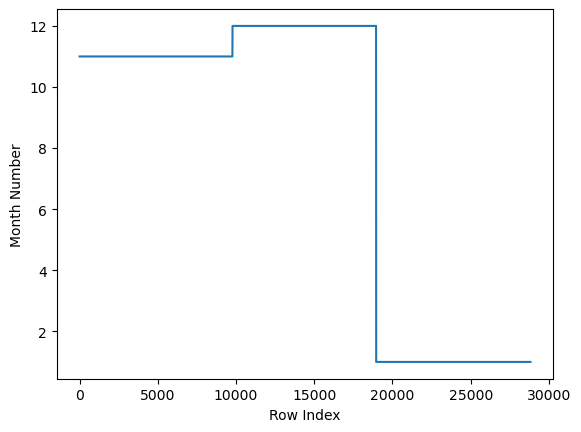

In [25]:
plt.plot(df_takeoff['MONTH'])
plt.ylabel('Month Number')
plt.xlabel('Row Index')

In [26]:
df_takeoff['MONTH'].unique()

array([11, 12,  1], dtype=int64)

In [27]:
def convert_to_datetime(df: pd.DataFrame):
    df['YEAR'] = np.where(df['MONTH'] == 1, 2020, 2019)
    date_time = df.apply(
        lambda row: '%04d-%02d-%02d %02d:%02d:00' % (
            row['YEAR'], row['MONTH'], row['DAY_OF_MONTH'],
            row['CRS_DEP_M'] // 60, row['CRS_DEP_M'] % 60 # assuming these values are number of minutes past midnight
        ),
        axis=1
    )
    df.drop(columns=['YEAR'], inplace=True)
    return pd.to_datetime(date_time)

date = convert_to_datetime(df_takeoff)
date.head()

0   2019-11-01 05:24:00
1   2019-11-01 05:40:00
2   2019-11-01 05:01:00
3   2019-11-01 05:45:00
4   2019-11-01 06:00:00
dtype: datetime64[ns]

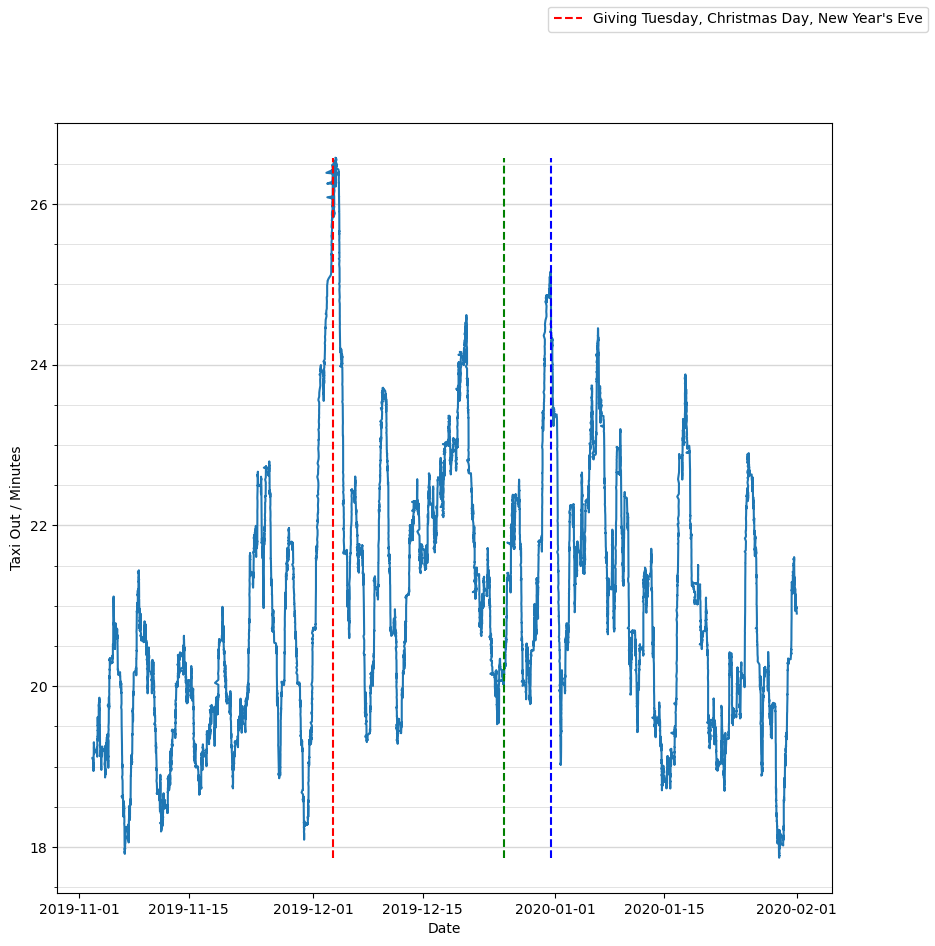

In [28]:
rolling_mean = df_takeoff['TAXI_OUT'].rolling(500).mean()

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
# ax.scatter(date, rolling_mean, s=5.0)
ax.plot(date, rolling_mean)

ax.vlines(
    [pd.to_datetime(['2019-12-03 12:00:00', '2019-12-25 12:00:00', '2019-12-31 12:00:00'])],
    ymin=rolling_mean.min(),
    ymax=rolling_mean.max(),
    colors=['r', 'g', 'b'],
    linestyles='dashed',
    label="Giving Tuesday, Christmas Day, New Year's Eve"
)

ax.set_xlabel('Date')
ax.set_ylabel('Taxi Out / Minutes')
fig.legend()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_axisbelow(True) # display grid behind other plot elements
ax.grid(visible=True, axis='y', which='major', linewidth=1.0, alpha=0.5)
ax.grid(visible=True, axis='y', which='minor', linewidth=0.5, alpha=0.5)

'TAXI_OUT' appears to peak around New Year's and, oddly, Giving Tuesday...

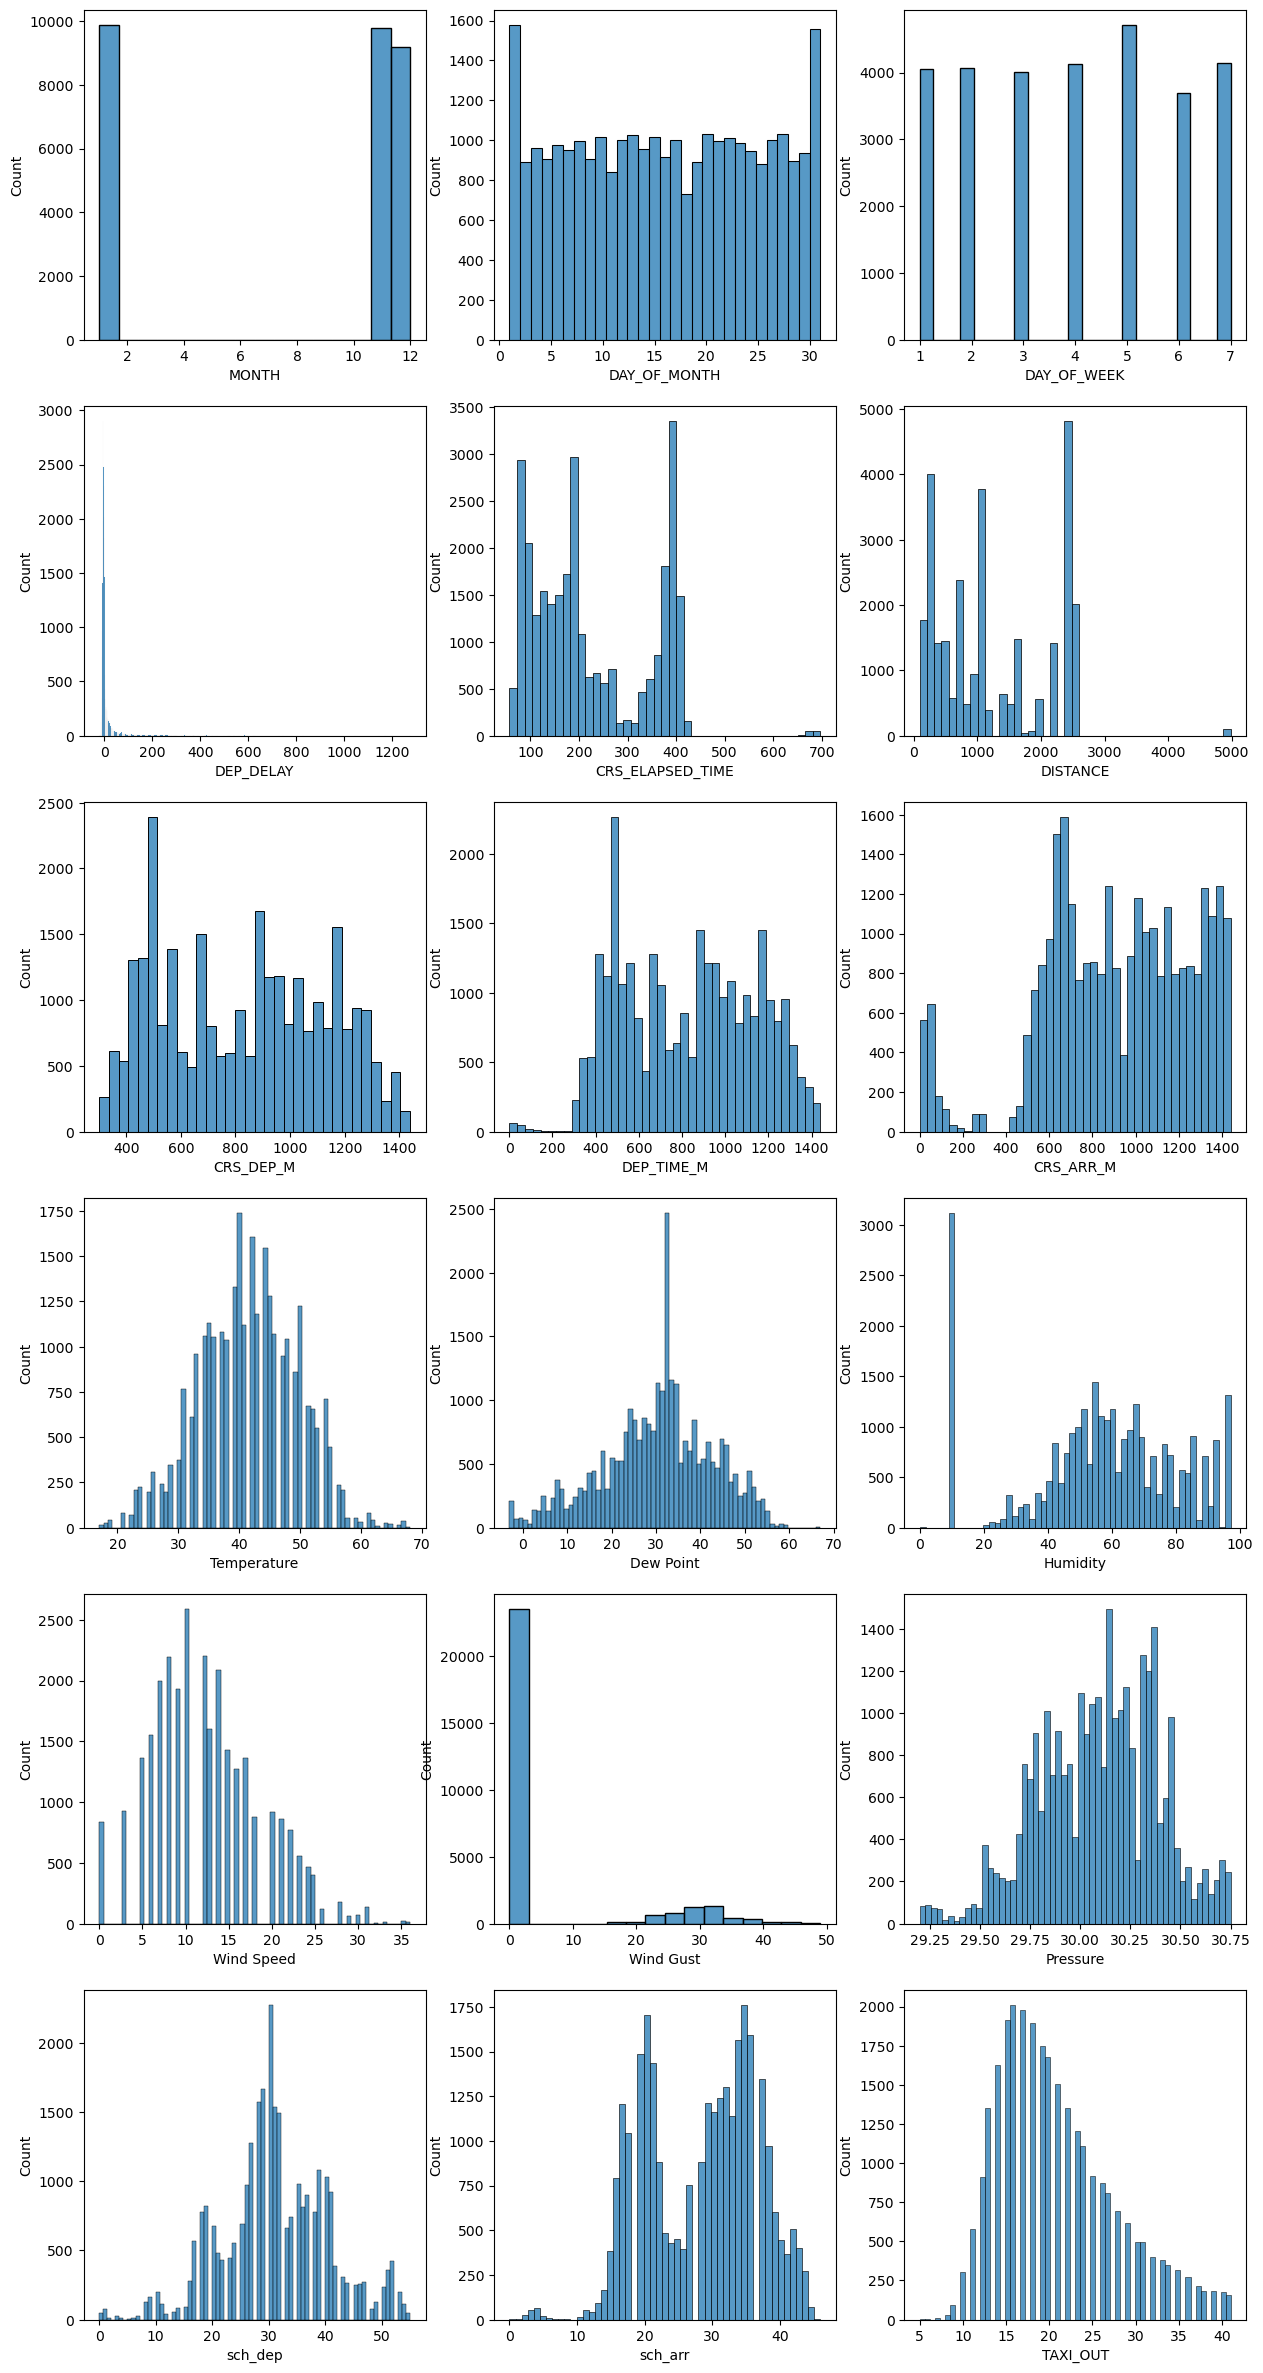

In [29]:
fig, axs = plt.subplots(*df_takeoff.select_dtypes(['int64', 'float64']).columns.to_numpy().reshape([-1, 3]).shape)
fig.set_figwidth(15)
fig.set_figheight(30)

for i, ax in enumerate(axs.flatten()):
    sns.histplot(df_takeoff.select_dtypes(['int64', 'float64']).iloc[:, i], ax=ax)


Wind Gust and Humidity have many outliers which will affect the scaling as part of the model preprocessing

<Axes: title={'center': 'Humidity'}, ylabel='Humidity'>

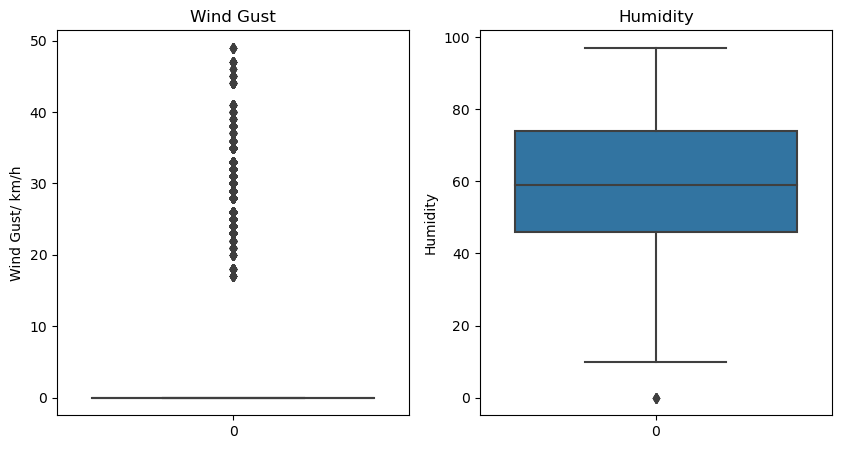

In [30]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.set_ylabel('Wind Gust/ km/h')
ax.set_title('Wind Gust')
sns.boxplot(df_takeoff['Wind Gust'])

ax1 = fig.add_subplot(122)
ax1.set_ylabel('Humidity')
ax1.set_title('Humidity')
sns.boxplot(df_takeoff['Humidity'])

# Investigate Scaling

Try different scaling methods to see which is best for different distributions presented by features

In [31]:
RANDOM_STATE = 42

scalers = {
    'Robust': RobustScaler(quantile_range=(25, 75)),
    'Power': PowerTransformer(method='yeo-johnson'),
    'Quantile (Gaussian)': QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE),
    'Standard': StandardScaler(),
}

columns = ['DEP_DELAY', 'Wind Gust', 'Humidity', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH']

scaled_features = []
for scaler in scalers.values():
    scaled_features.append(
        scaler.fit_transform(
            df_takeoff.loc[:, columns]
        )
    )

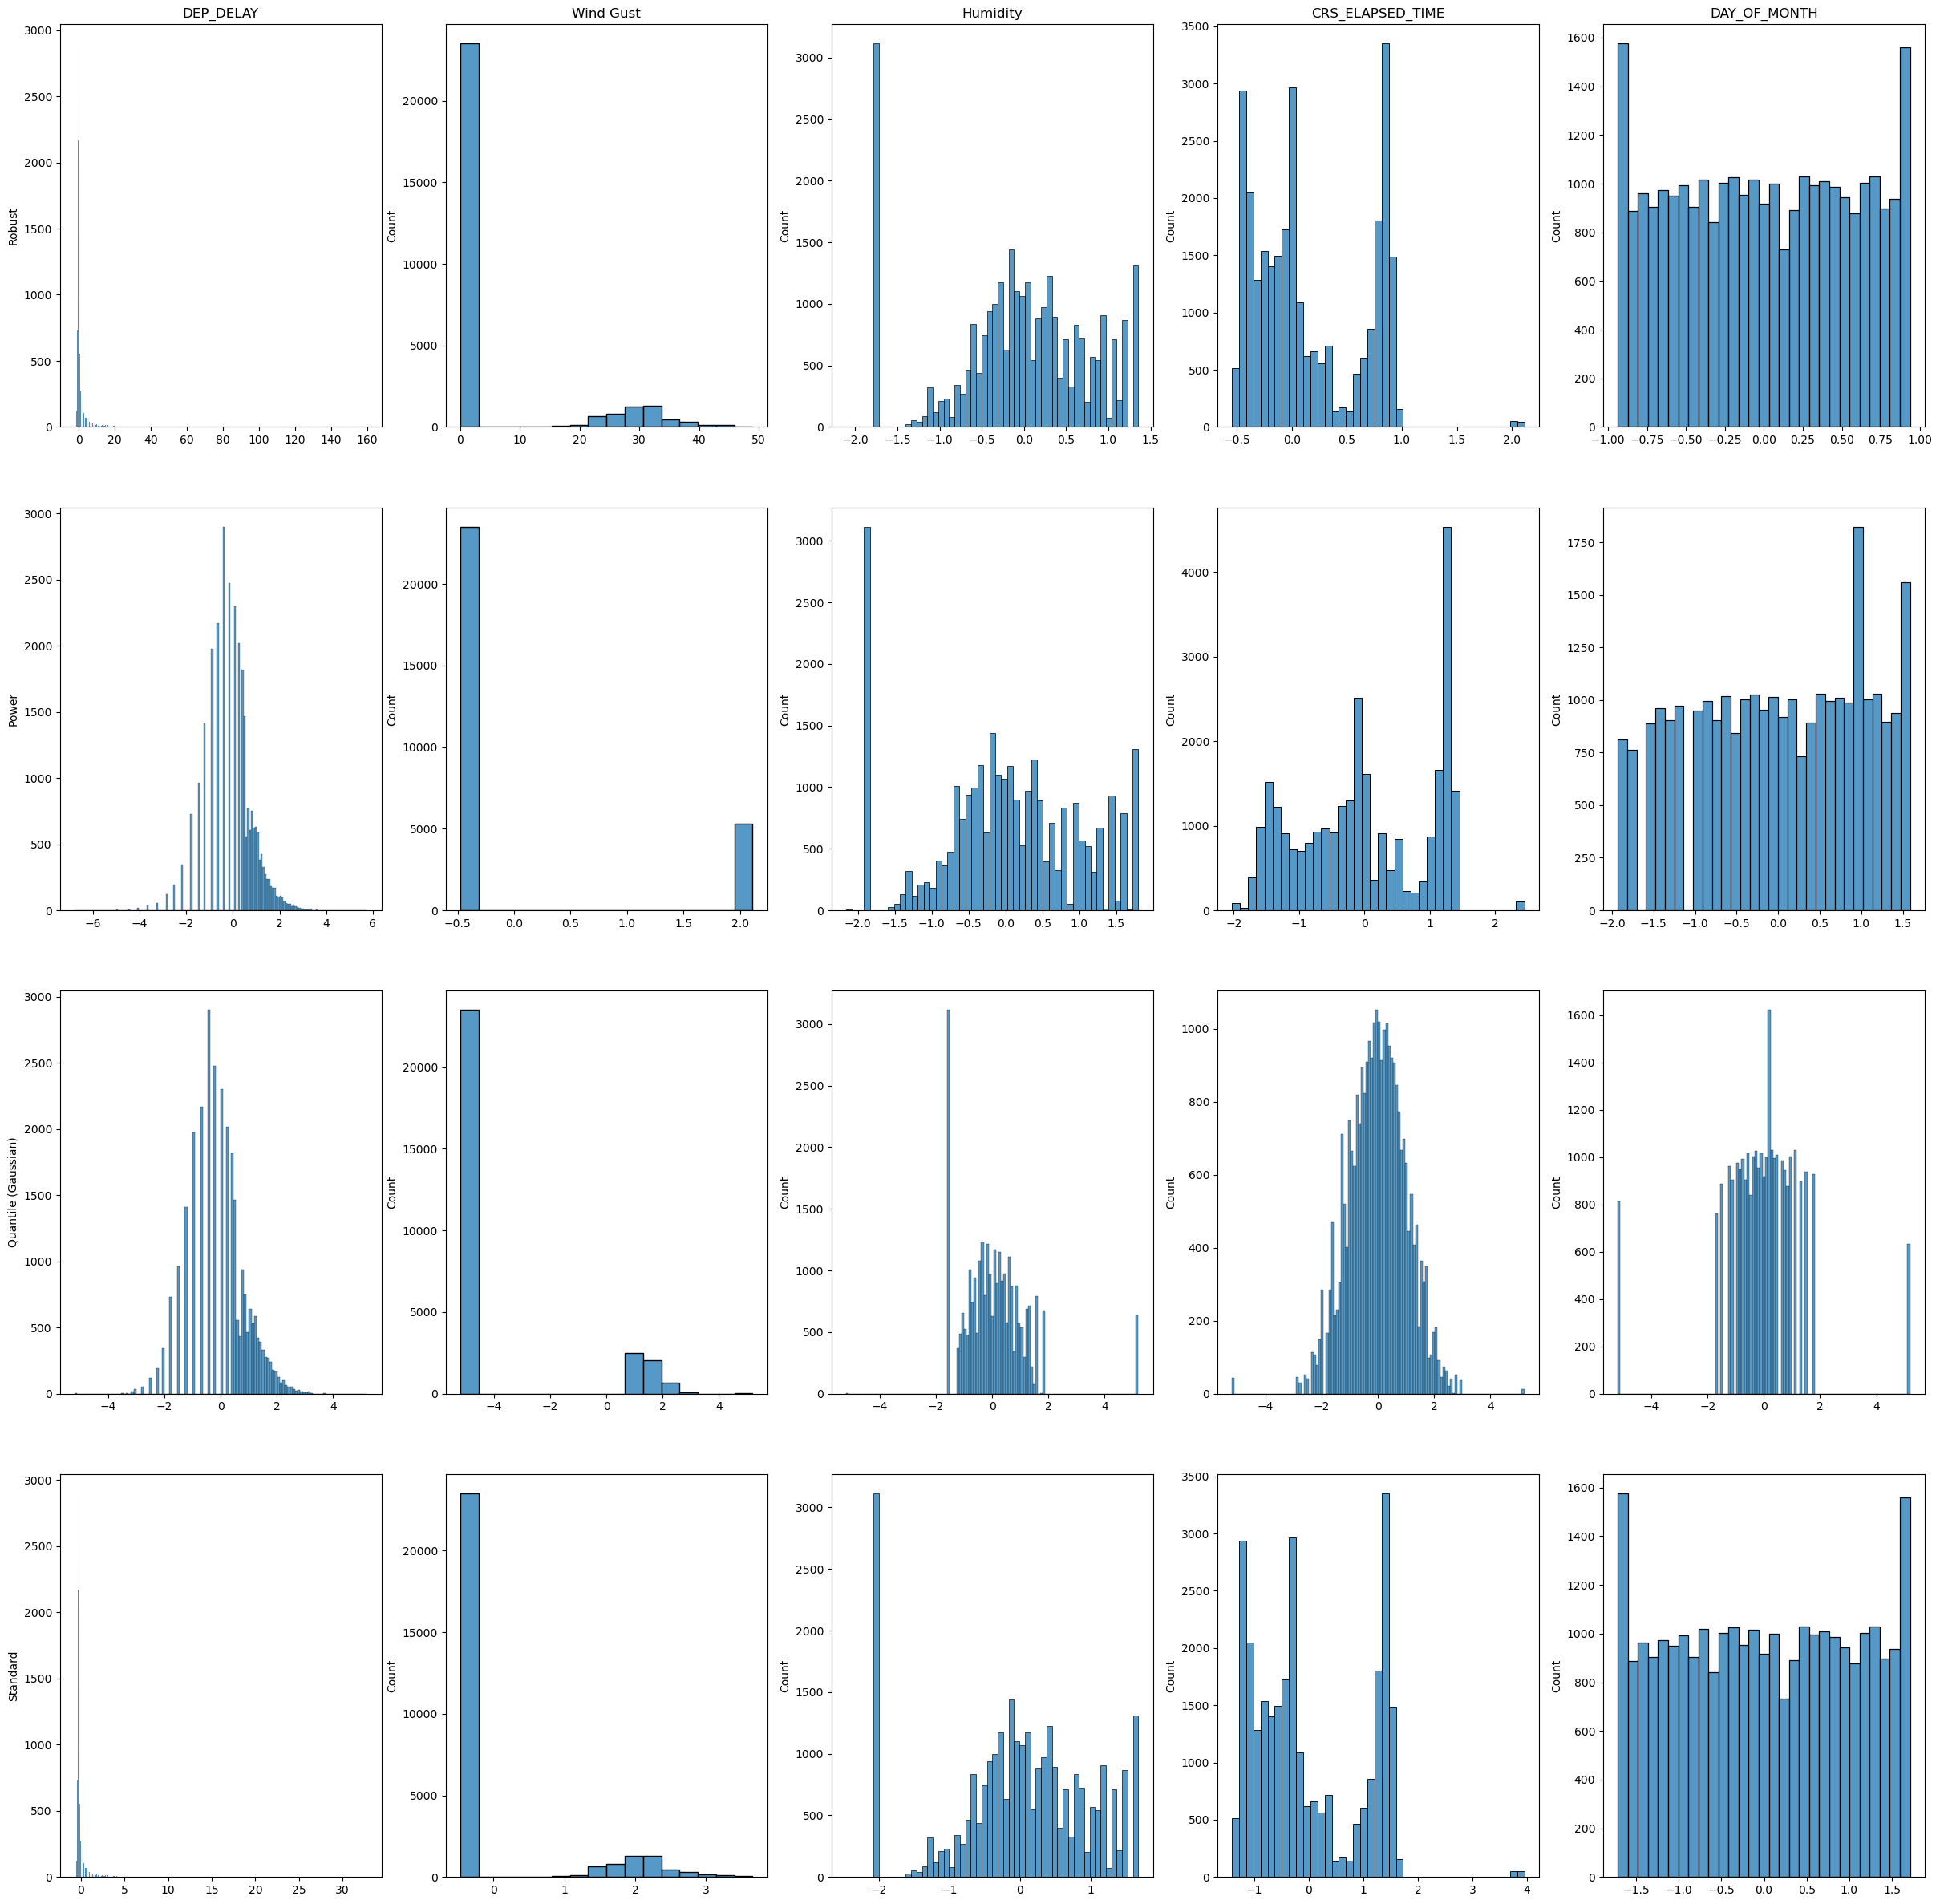

In [32]:
num_rows = len(scalers)
num_cols = len(columns)

fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(30)
fig.set_figheight(30)

for r, scaler in enumerate(scalers.keys()):
    axs[r, 0].set_ylabel(scaler)

for c, title in enumerate(columns):
    axs[0, c].set_title(title)

for i, ax in enumerate(axs.flatten()):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(scaled_features[row][:, col], ax=ax)

- DEP_DELAY: Power and Quantile work well
- Wind Gust: I'm not sure which is best
- Humidity : Not Quantile, but the rest seem to be much of a muchness
- sch_arr  : Quantile works best to squeeze the binomial distribution into a more Gaussian looking one